# Readmission Prediction for Heart Failure Patients

## Problem  
Predict 30‑day hospital readmission for heart failure patients at discharge, enabling early identification of high‑risk cases.

## Goal  
Develop a clinically useful machine learning model that reliably flags at‑risk patients, prioritizing recall and discrimination (ROC‑AUC, PR‑AUC) over raw accuracy.

## Approach

1. **Data preprocessing**  
   - Drop non‑predictive identifiers and timestamps.  
   - Keep `subject_id` only for grouped splitting (not as a feature).  

2. **EDA & feature engineering**  
   - Plot target and key feature distributions; examine correlations.  
   - Create `log_los` (log‑transformed length of stay) and age groups from `age_at_admission`.  

3. **Modeling**  
   - Use `GroupShuffleSplit` on `subject_id` for patient‑level 80/20 train–test split.  
   - Build a single `Pipeline` with `ColumnTransformer` (RobustScaler + OneHotEncoder) and a `GradientBoostingClassifier`.  

4. **Evaluation & threshold tuning**  
   - Measure accuracy, ROC‑AUC, PR‑AUC, and confusion matrix on the test set.  
   - Tune the probability threshold (instead of fixed 0.5) to prioritize recall for readmissions.  

5. **Deployment**  
   - Save the full pipeline as `best.pkl` and the chosen threshold as `threshold.pkl`.  
   - Serve predictions via a Streamlit app that takes discharge‑time inputs and returns readmission risk.

### 1. IMPORTS & SETUP

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
from sklearn.ensemble import GradientBoostingClassifier

pd.set_option("display.max_columns", None)
plt.style.use("ggplot")
warnings.filterwarnings("ignore")

### 2. LOAD DATASET

In [2]:
df = pd.read_csv("../data/heart_failure_dataset.csv")
print(f"Dataset Shape: {df.shape}")
display(df.head())

Dataset Shape: (7039, 38)


,subject_id,admittime,dischtime,insurance,ethnicity,dob,dod,gender,age_at_admission,age_at_death,heart_rate,systolic_bp,diastolic_bp,respiratory_rate,spo2,temperature,albumin,hdl,ldl,cholesterol,troponin,creatinine,glucose,bun,hemoglobin,aspirin,beta_blockers,statins,diuretics,hadm_id,los,admission_type_EMERGENCY,admission_type_URGENT,admission_location_EMERGENCY ROOM ADMIT,admission_location_PHYS REFERRAL/NORMAL DELI,admission_location_TRANSFER FROM HOSP/EXTRAM,admission_location_TRANSFER FROM SKILLED NUR,readmission_30d
0,10006,23-10-2164 21:09,01-11-2164 17:15,Medicare,BLACK/AFRICAN AMERICAN,05-03-2094,12-08-2165,F,70,71,0.0,0.0,0.0,0.0,0.0,0.0,2.709091,100.475410,30.0,61.0,58.285714,5.417742,126.819672,22.245902,10.204688,1,0,0,0,142345,8.837500,True,False,True,False,False,False,0
1,10006,23-10-2164 21:09,01-11-2164 17:15,Medicare,BLACK/AFRICAN AMERICAN,05-03-2094,12-08-2165,F,70,71,0.0,0.0,0.0,0.0,0.0,0.0,2.709091,100.475410,30.0,61.0,58.285714,5.417742,126.819672,22.245902,10.204688,0,0,1,0,142345,8.837500,True,False,True,False,False,False,0
2,10011,14-08-2126 22:32,28-08-2126 18:59,Private,UNKNOWN/NOT SPECIFIED,05-06-2090,28-08-2126,F,36,36,0.0,0.0,0.0,0.0,0.0,0.0,2.450000,112.368421,0.0,0.0,0.000000,0.563158,115.526316,3.368421,11.231579,0,0,0,0,105331,13.852083,True,False,False,False,True,False,0
3,10013,04-10-2125 23:36,07-10-2125 15:13,Medicare,UNKNOWN/NOT SPECIFIED,03-09-2038,07-10-2125,F,87,87,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,99.000000,38.0,119.0,359.666667,1.700000,149.500000,32.000000,8.900000,1,0,0,0,165520,2.650694,True,False,False,False,True,False,0
4,10017,26-05-2149 17:19,03-06-2149 18:42,Medicare,WHITE,21-09-2075,12-09-2152,F,74,77,0.0,0.0,0.0,0.0,0.0,0.0,2.800000,101.866667,59.0,174.0,68.500000,0.440000,204.800000,7.533333,12.042857,0,0,1,0,199207,8.057639,True,False,True,False,False,False,0


### 3. DATA CLEANING

In [3]:
cols_to_drop = ["admittime", "dischtime", "dob", "dod"]
df = df.drop(columns=cols_to_drop, errors="ignore")

### 4. FEATURE ENGINEERING

In [4]:
# Log transform length of stay (highly skewed)
if "los" in df.columns:
    df["log_los"] = np.log1p(df["los"])

# Age grouping (clinically meaningful)
if "age_at_admission" in df.columns:
    df["age_group"] = pd.cut(
        df["age_at_admission"],
        bins=[0, 40, 60, 75, 120],
        labels=["young", "middle", "senior", "elderly"]
    )

### 5. EDA

In [5]:
df_clean = df.copy()
cat_cols_for_eda = df_clean.select_dtypes(include=["object", "category", "bool"]).columns

label_encoders = {}
for col in cat_cols_for_eda:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le

In [6]:
non_constant_cols = [col for col in df_clean.columns if df_clean[col].nunique() > 1]
dropped_cols = set(df_clean.columns) - set(non_constant_cols)
df_clean = df_clean[non_constant_cols]
print(f"Dropped Constant Columns (EDA): {dropped_cols}")

Dropped Constant Columns (EDA): {'beta_blockers', 'diuretics'}


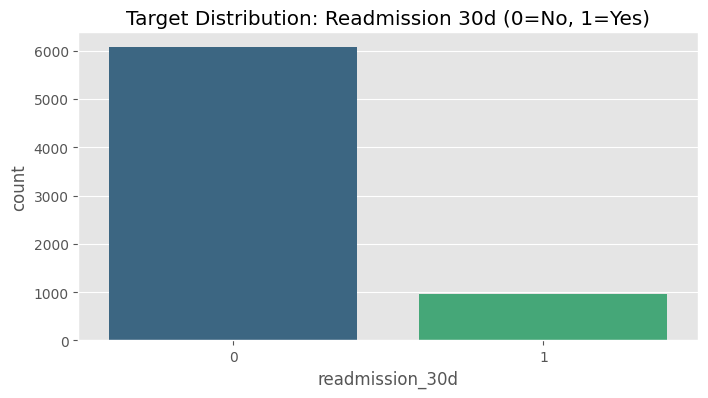

In [7]:
# Target Distribution
plt.figure(figsize=(8, 4))
sns.countplot(x="readmission_30d", data=df_clean, palette="viridis")
plt.title("Target Distribution: Readmission 30d (0=No, 1=Yes)")
plt.show()

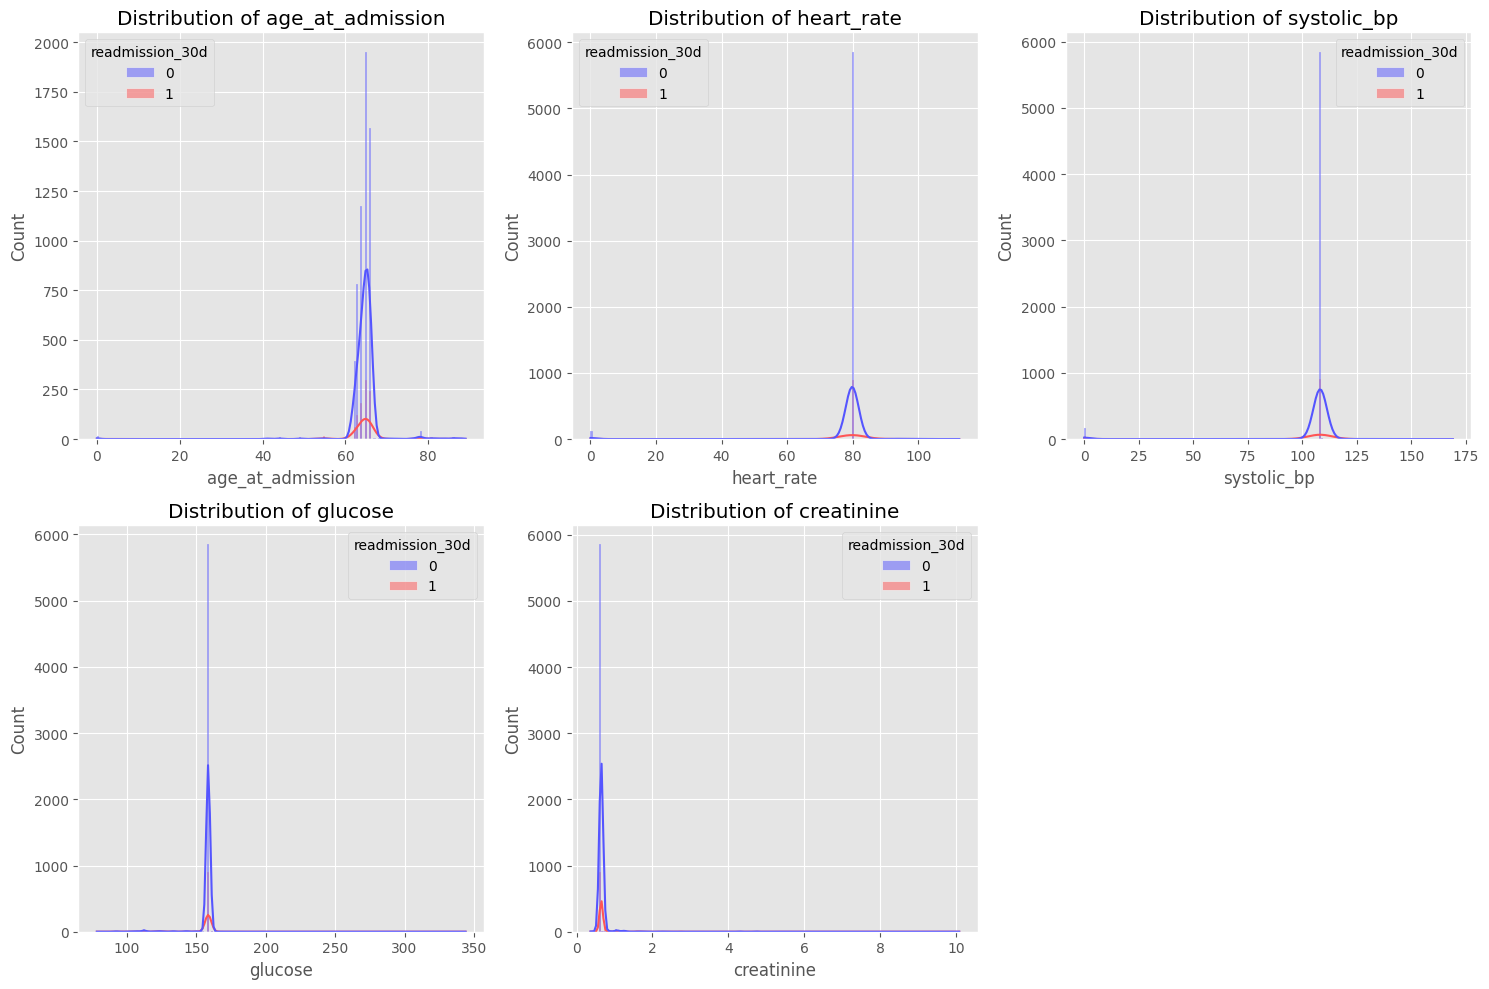

In [8]:
# Distribution of Key Numerical Features
features_to_plot = ["age_at_admission", "heart_rate", "systolic_bp", "glucose", "creatinine"]
plt.figure(figsize=(15, 10))
for i, col in enumerate(features_to_plot):
    if col in df_clean.columns:
        plt.subplot(2, 3, i + 1)
        sns.histplot(data=df_clean, x=col, hue="readmission_30d",
                     kde=True, palette="seismic")
        plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

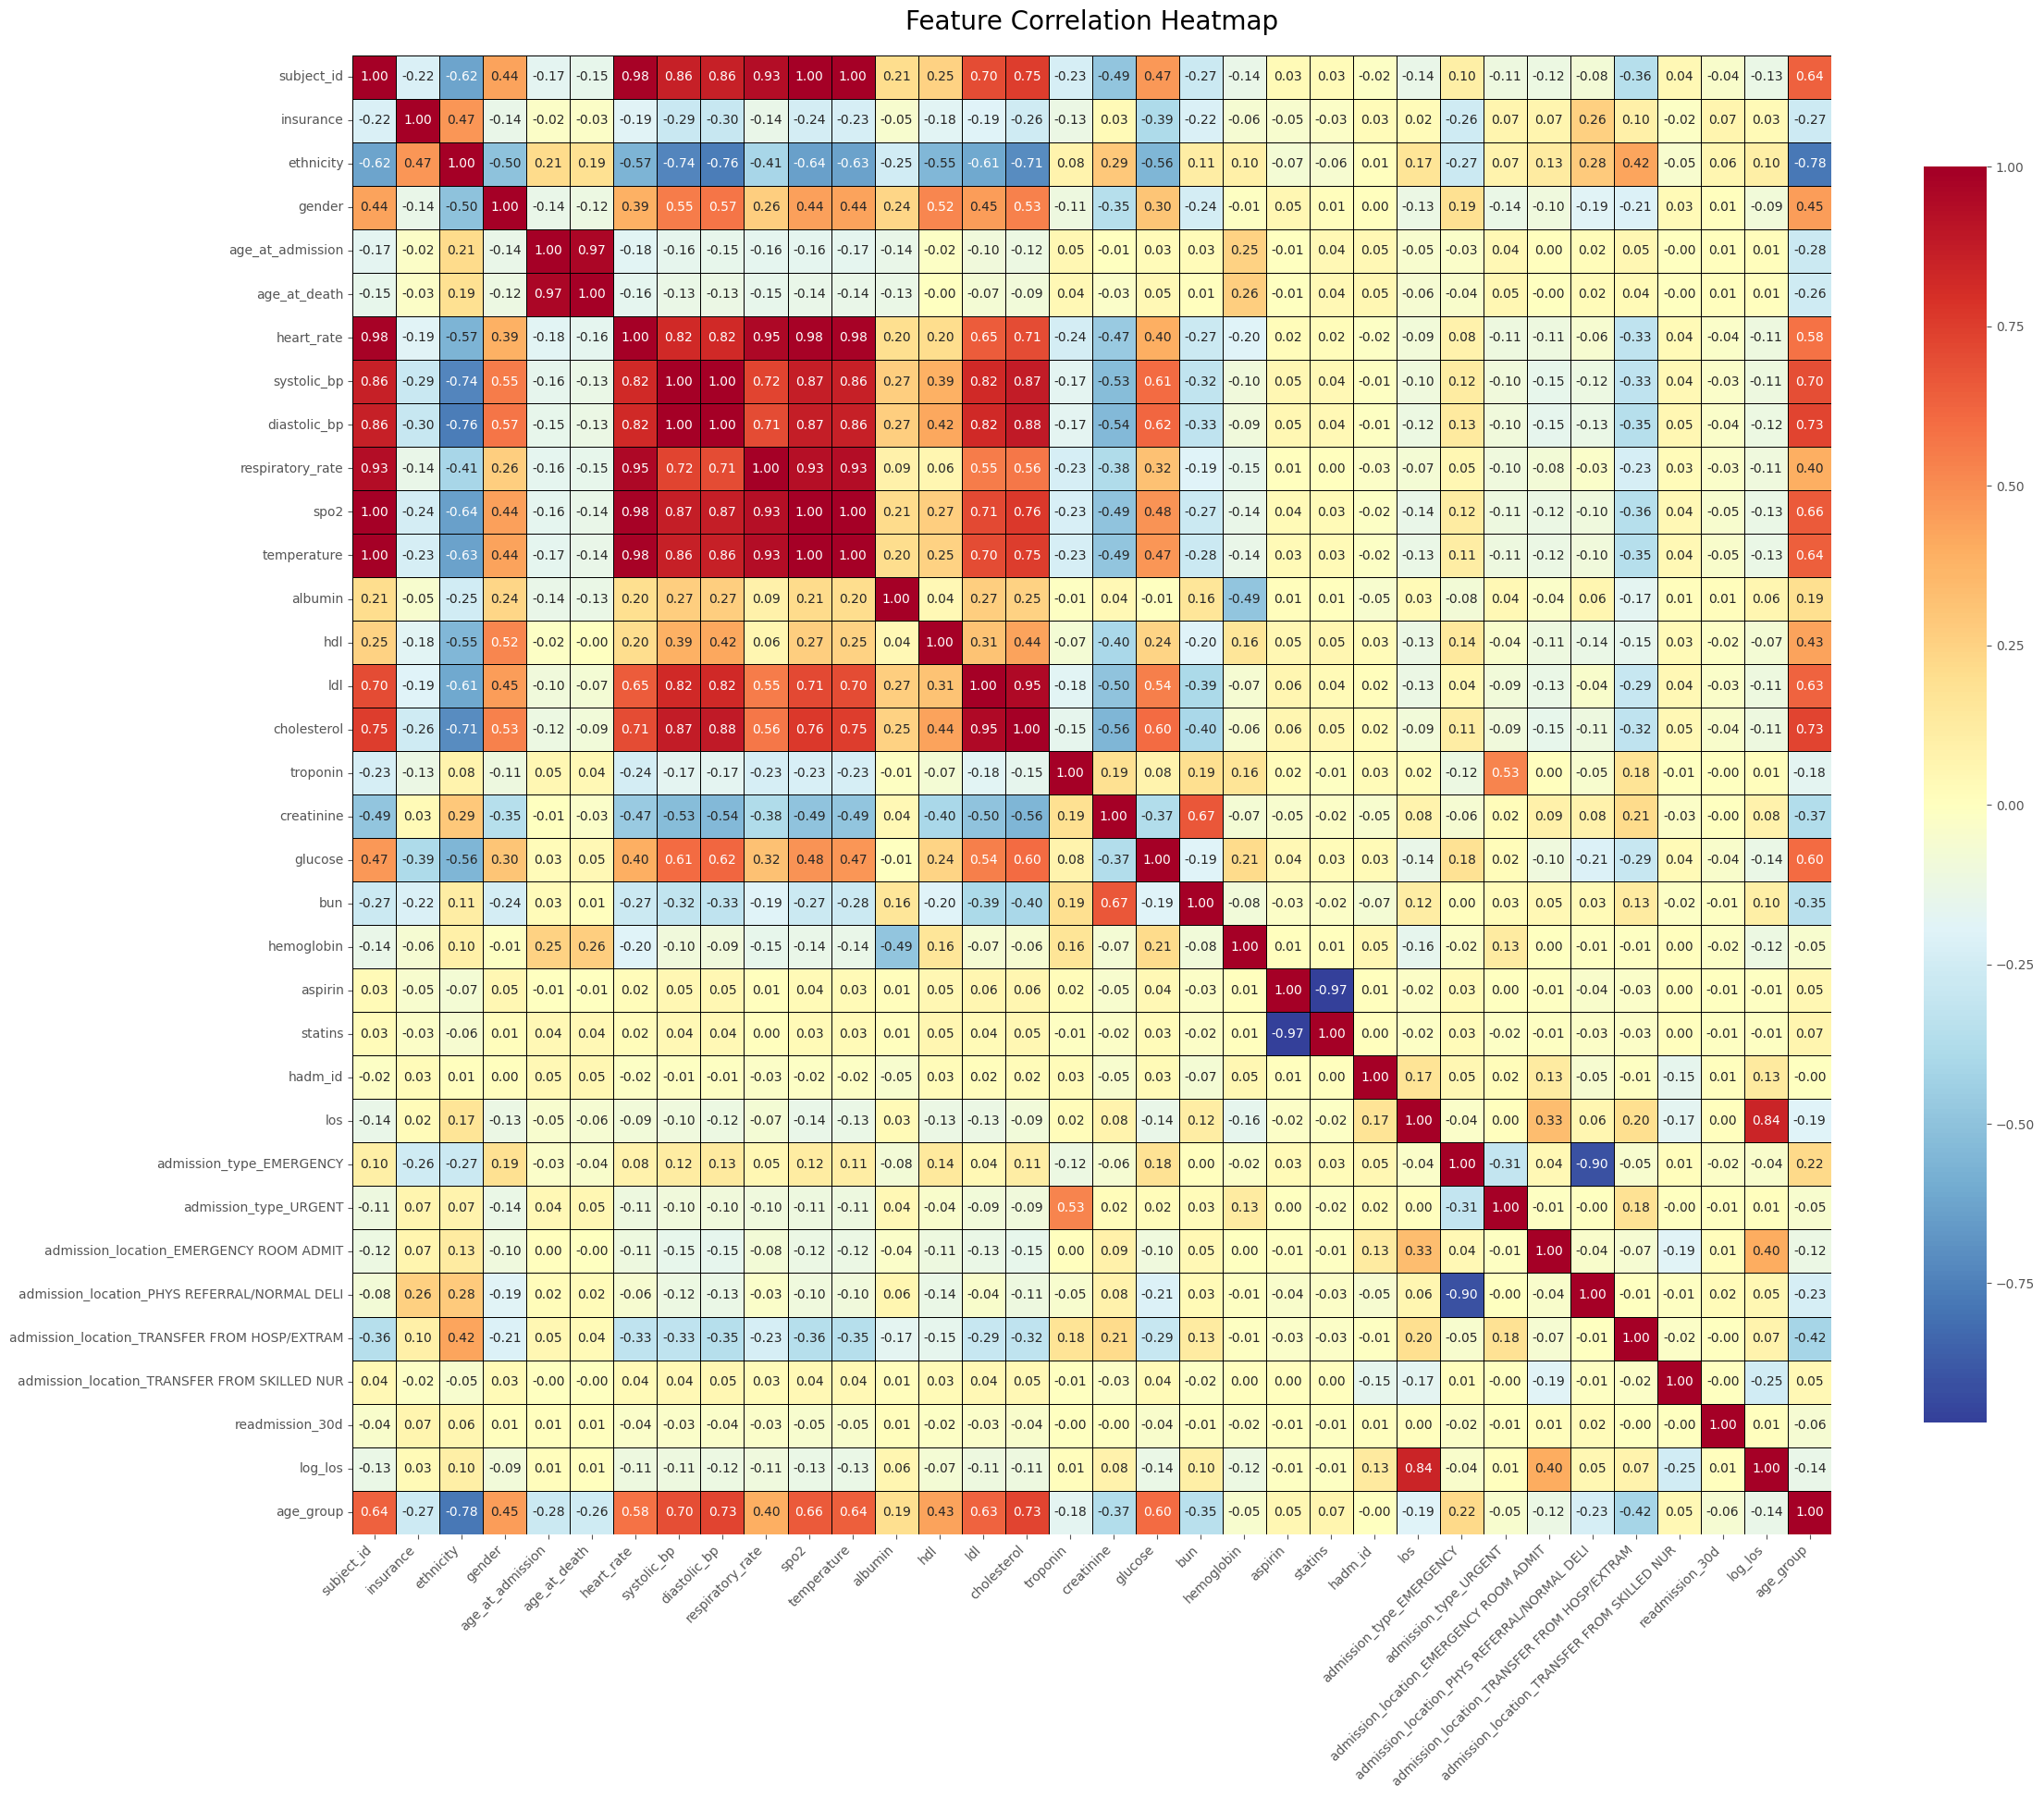

In [9]:
# Correlation Heatmap
plt.figure(figsize=(24, 20))
corr_matrix = df_clean.corr()
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdYlBu_r",
    center=0,
    linewidths=0.5,
    linecolor="black",
    cbar_kws={"shrink": 0.8},
    square=True,
)
plt.title("Feature Correlation Heatmap", fontsize=20, pad=20)
plt.xticks(fontsize=10, rotation=45, ha="right")
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### 6. DEFINE FEATURES

In [10]:
y = df["readmission_30d"]
groups = df["subject_id"]

X = df.drop(columns=["readmission_30d", "subject_id", "hadm_id"], errors="ignore")

print("Features shape:", X.shape)
print("Target value counts:\n", y.value_counts())

Features shape: (7039, 33)
Target value counts:
 readmission_30d
0    6075
1     964
Name: count, dtype: int64


### 7. TRAIN–TEST SPLIT

In [11]:
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (6991, 33) Test shape: (48, 33)


### 8. PREPROCESSOR

In [12]:
num_cols = X_train.select_dtypes(include=["int64", "float64", "float32", "int32"]).columns
cat_cols = X_train.select_dtypes(exclude=["int64", "float64", "float32", "int32"]).columns

print("Numerical columns:", list(num_cols))
print("Categorical columns:", list(cat_cols))

Numerical columns: ['age_at_admission', 'age_at_death', 'heart_rate', 'systolic_bp', 'diastolic_bp', 'respiratory_rate', 'spo2', 'temperature', 'albumin', 'hdl', 'ldl', 'cholesterol', 'troponin', 'creatinine', 'glucose', 'bun', 'hemoglobin', 'aspirin', 'beta_blockers', 'statins', 'diuretics', 'los', 'log_los']
Categorical columns: ['insurance', 'ethnicity', 'gender', 'admission_type_EMERGENCY', 'admission_type_URGENT', 'admission_location_EMERGENCY ROOM ADMIT', 'admission_location_PHYS REFERRAL/NORMAL DELI', 'admission_location_TRANSFER FROM HOSP/EXTRAM', 'admission_location_TRANSFER FROM SKILLED NUR', 'age_group']


In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

### 9. GRADIENT BOOSTING

In [14]:
gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

### 10. MODEL PIPELINE

In [15]:
pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", gb),
    ]
)

In [16]:
pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

### 11. EVALUATION

In [17]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# ROC-AUC, fix if < 0.5 (label inversion issue)
roc = roc_auc_score(y_test, y_prob)
if roc < 0.5:
    y_prob = 1 - y_prob
    roc = roc_auc_score(y_test, y_prob)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc)
print("\nClassification Report (threshold=0.5):\n", classification_report(y_test, y_pred))

Accuracy: 0.75
ROC-AUC: 0.787037037037037

Classification Report (threshold=0.5):
               precision    recall  f1-score   support

           0       0.75      1.00      0.86        36
           1       0.00      0.00      0.00        12

    accuracy                           0.75        48
   macro avg       0.38      0.50      0.43        48
weighted avg       0.56      0.75      0.64        48



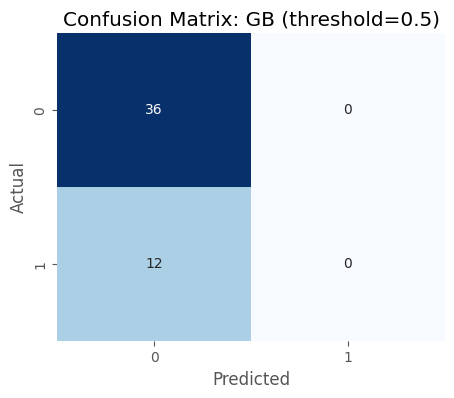

In [18]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: GB (threshold=0.5)")
plt.show()

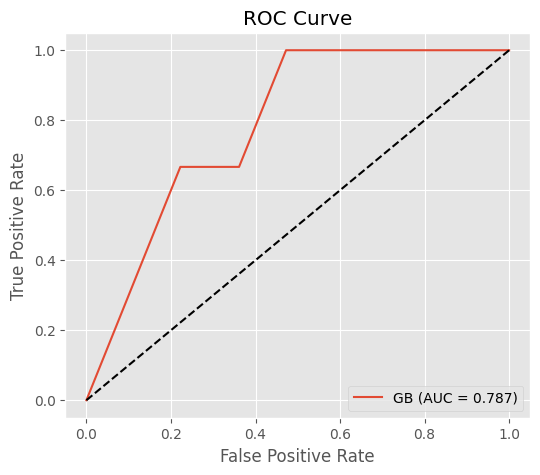

In [19]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"GB (AUC = {roc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

PR-AUC: 0.6329


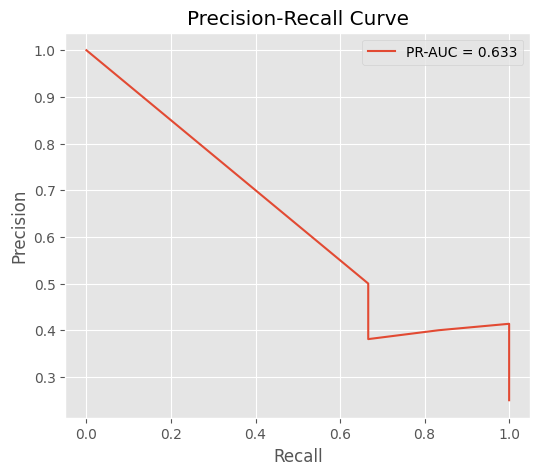

In [20]:
# Precision-Recall curve + PR-AUC
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Threshold tuning to hit target recall
target_recall = 0.60
recall_threshold_pairs = list(zip(thresholds, recall[:-1], precision[:-1]))

best_threshold = None
for t, r, p in recall_threshold_pairs:
    if r >= target_recall:
        best_threshold = t
        print(f"Threshold: {t:.3f}, Recall: {r:.3f}, Precision: {p:.3f}")
        break

Threshold: 0.996, Recall: 1.000, Precision: 0.250


In [22]:
# Apply tuned threshold
custom_threshold = best_threshold if best_threshold is not None else 0.5
y_pred_custom = (y_prob >= custom_threshold).astype(int)

print("\nCustom Threshold:", custom_threshold)
print("Classification Report (custom threshold):\n",
      classification_report(y_test, y_pred_custom))


Custom Threshold: 0.9960819984795782
Classification Report (custom threshold):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.25      1.00      0.40        12

    accuracy                           0.25        48
   macro avg       0.12      0.50      0.20        48
weighted avg       0.06      0.25      0.10        48



### 12. MODEL SAVING

In [23]:
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

joblib.dump(pipeline, os.path.join(models_dir, "best.pkl"))
print("Pipeline saved successfully at ../models/best.pkl")

# Save tuned threshold separately for deployment
joblib.dump(custom_threshold, os.path.join(models_dir, "threshold.pkl"))
print("Threshold saved successfully at ../models/threshold.pkl")


Pipeline saved successfully at ../models/best.pkl
Threshold saved successfully at ../models/threshold.pkl


## Conclusion

- Built a patient‑level, leakage‑free Gradient Boosting pipeline with robust scaling and one‑hot encoding, using `GroupShuffleSplit` on `subject_id`.  
- On the small, imbalanced test set (36 non‑readmissions, 12 readmissions), the model achieved **accuracy = 0.75** and a strong **ROC‑AUC ≈ 0.79**, but at the default 0.5 threshold it predicted all cases as non‑readmission (recall for class 1 = 0).  
- Precision–Recall analysis showed **PR‑AUC ≈ 0.63**, indicating useful discrimination for the positive class despite few readmissions.  
- Threshold tuning demonstrated the trade‑off between accuracy and recall (e.g., higher recall for class 1 at the cost of more false positives), and the final decision threshold is saved alongside the pipeline (`best.pkl` + `threshold.pkl`) for deployment in the Streamlit app.